In [1]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler

postgresql_jdbc_jar = r"C:/Program Files/PostgreSQL/17/postgresql-42.7.4.jar"
spark = SparkSession.builder.appName('modeldevelopment')\
                            .config("spark.jars", postgresql_jdbc_jar) \
                            .config("spark.driver.extraClassPath", postgresql_jdbc_jar) \
                            .config("spark.driver.memory", "8g")\
                            .config("spark.executor.memory", "8g")\
                            .config("spark.executor.cores", "4")\
                            .getOrCreate()

### Reading the data

In [2]:
# Database connection parameters
url = "jdbc:postgresql://localhost:5432/postgres"
properties = {
    "user": "postgres",
    "password": "root",
    "driver": "org.postgresql.Driver"
}

# Load the data into a PySpark DataFrame
df_model = spark.read.jdbc(url=url, table='feature_engineering_delivery', properties=properties)
# df_c = spark.read.jdbc(url=url, table='delivery_data', properties=properties)

# df_c_selected = df_c.select('order_id', 'delivery_time', 'city', 'accept_time', 'lng', 'lat')

# df_model = df_p.join(df_c_selected, on='order_id', how='left')

In [3]:
df_model.printSchema()

root
 |-- delivery_time: timestamp (nullable = true)
 |-- accept_time: timestamp (nullable = true)
 |-- city: string (nullable = true)
 |-- is_delayed: string (nullable = true)
 |-- speed_status: string (nullable = true)
 |-- pca1: double (nullable = true)
 |-- pca2: double (nullable = true)
 |-- pca3: double (nullable = true)
 |-- pca4: double (nullable = true)
 |-- pca5: double (nullable = true)
 |-- pca6: double (nullable = true)
 |-- pca7: double (nullable = true)
 |-- pca8: double (nullable = true)
 |-- pca9: double (nullable = true)
 |-- delivery_eta_minutes: double (nullable = true)



In [15]:
df_model.select("delivery_eta_minutes").summary().show()

+-------+--------------------+
|summary|delivery_eta_minutes|
+-------+--------------------+
|  count|              530612|
|   mean|  193.06754841579158|
| stddev|    663.518670011278|
|    min|                 0.0|
|    25%|                54.0|
|    50%|                99.0|
|    75%|               189.0|
|    max|            127519.0|
+-------+--------------------+



###  Train-Test Split – Using a time-based split for proper validation

In [61]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col
from pyspark.sql import SparkSession

# Load Data (Assuming df_model is already a Spark DataFrame)
df_split = df_model.drop("delivery_time", "accept_time", "city")  # Drop unnecessary columns

# Convert `is_delayed` (Categorical Target) to Numeric
indexer = StringIndexer(inputCol="is_delayed", outputCol="is_delayed_index", handleInvalid="keep")
df_split = indexer.fit(df_split).transform(df_split)

# Convert `is_delayed` (Categorical Target) to Numeric
speed_status_indexer = StringIndexer(inputCol="speed_status", outputCol="speed_status_indexed", handleInvalid="keep")
df_split = speed_status_indexer.fit(df_split).transform(df_split)

# Drop `speed_status` after indexing
df_split = df_split.drop("speed_status")

# Define Features and Targets
feature_cols = [col for col in df_split.columns if col not in ["is_delayed", "delivery_eta_minutes", "is_delayed_index"]]

# Train-Test Split (80%-20%)
train_data, test_data = df_split.randomSplit([0.8, 0.2], seed=42)

# Split Data for Classification (Delay Detection)
train_cls = train_data.select(*feature_cols, "is_delayed_index")
test_cls = test_data.select(*feature_cols, "is_delayed_index")

# Split Data for Regression (ETA Prediction)
train_reg = train_data.select(*feature_cols, "delivery_eta_minutes")
test_reg = test_data.select(*feature_cols, "delivery_eta_minutes")

# Show Data Sizes
print(f"Total Data Size: {df_split.count()}")
print(f"Training Data Size: {train_data.count()}")
print(f"Testing Data Size: {test_data.count()}")

print(f"Classification Train Size: {train_cls.count()}, Test Size: {test_cls.count()}")
print(f"Regression Train Size: {train_reg.count()}, Test Size: {test_reg.count()}")

Total Data Size: 530612
Training Data Size: 424362
Testing Data Size: 106250
Classification Train Size: 424362, Test Size: 106250
Regression Train Size: 424362, Test Size: 106250


### Model Selection:

#### Regression models for ETA prediction (XGBoost, Random Forest, Linear Regression).

In [4]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Estimator
from pyspark.sql.functions import col
import numpy as np
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pyspark.ml import Pipeline

##### ETA prediction using XGBoost, Random Forest, Linear Regression

In [63]:
features = ["pca1", "pca2", "pca3", "pca4", "pca5", "pca6", "pca7", "pca8", "pca9"]

# Convert Categorical Column (`speed_status`) into Numeric
# speed_status_indexer = StringIndexer(inputCol="speed_status", outputCol="speed_status_indexed", handleInvalid="keep")

# final_features = features + ["speed_status_indexed"]  # updated feature list including indexed column

# Assemble Features for Regression
assembler_reg = VectorAssembler(inputCols=features, outputCol="features")

# Create Regression Pipeline
pipeline_reg = Pipeline(stages=[assembler_reg])

# Fit & Transform Train-Test Data for Regression
train_data_features = pipeline_reg.fit(train_reg).transform(train_reg)
test_data_features = pipeline_reg.fit(train_reg).transform(test_reg)

In [65]:
# Model 1: Linear Regression
lr = LinearRegression(featuresCol='features', labelCol='delivery_eta_minutes')
lr_model = lr.fit(train_data_features)
lr_predictions = lr_model.transform(test_data_features)

# Model 2: Random Forest Regressor
rf = RandomForestRegressor(featuresCol='features', labelCol='delivery_eta_minutes')
rf_model = rf.fit(train_data_features)
rf_predictions = rf_model.transform(test_data_features)

# XGBoost Regressor (scikit-learn version)
# Convert train_data and test_data to Pandas DataFrame for scikit-learn models
train_df = train_data_features.select("features", 'delivery_eta_minutes').toPandas() # delivery_eta_minutes is the target
test_df = test_data_features.select("features", 'delivery_eta_minutes').toPandas() # delivery_eta_minutes is the target

# Convert the 'features' column from PySpark vector format to a list of numbers for scikit-learn
X_train_reg = np.array(train_df["features"].tolist())
y_train_reg = np.array(train_df["delivery_eta_minutes"])
X_test_reg = np.array(test_df["features"].tolist())
y_test_reg = np.array(test_df["delivery_eta_minutes"])

# Initialize and train XGBoost Regressor
xgb_reg = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_reg.fit(X_train_reg, y_train_reg)

# XGBoost Predictions
xgb_predictions_reg = xgb_reg.predict(X_test_reg)

In [66]:
# Evaluate the models using RMSE, MSE, and MAE
evaluator = RegressionEvaluator(labelCol="delivery_eta_minutes", predictionCol="prediction", metricName="rmse")

# Linear Regression Evaluation
rmse_lr = evaluator.evaluate(lr_predictions)
mse_lr = mean_squared_error(y_test_reg, lr_predictions.select('prediction').toPandas())
mae_lr = mean_absolute_error(y_test_reg, lr_predictions.select('prediction').toPandas())

# Random Forest Evaluation
rmse_rf = evaluator.evaluate(rf_predictions)
mse_rf = mean_squared_error(y_test_reg, rf_predictions.select('prediction').toPandas())
mae_rf = mean_absolute_error(y_test_reg, rf_predictions.select('prediction').toPandas())

# XGBoost Evaluation
rmse_xgb = np.sqrt(mean_squared_error(y_test_reg, xgb_predictions_reg))  # RMSE for XGBoost
mse_xgb = mean_squared_error(y_test_reg, xgb_predictions_reg)  # MSE for XGBoost
mae_xgb = mean_absolute_error(y_test_reg, xgb_predictions_reg)  # MAE for XGBoost

# Print evaluation results
print("Model Evaluation Results:")
print(f"Linear Regression - RMSE: {rmse_lr}, MSE: {mse_lr}, MAE: {mae_lr}")
print(f"Random Forest - RMSE: {rmse_rf}, MSE: {mse_rf}, MAE: {mae_rf}")
print(f"XGBoost - RMSE: {rmse_xgb}, MSE: {mse_xgb}, MAE: {mae_xgb}")

Model Evaluation Results:
Linear Regression - RMSE: 4.22259858347963, MSE: 17.8303387972044, MAE: 3.053355210044634
Random Forest - RMSE: 387.11968374782066, MSE: 149861.64954501062, MAE: 96.16916116257005
XGBoost - RMSE: 370.17414827283335, MSE: 137028.9000495176, MAE: 26.382690491900302


In [ ]:
#looking the values of RMSE, MSE, MAE for each model, all three values are lowest for Linear Regression so this is he best fit model.

##### Hyperparameter Tuning & Evaluation for XGBOOST – Optimizing model performance.

In [18]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import gc

# Collect Garbage
gc.collect()

# Define XGBoost Regressor Model with GPU
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Hyperparameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [75, 100],
    'learning_rate': [0.1, 0.2],
    'max_depth': [4, 6, 7],
    'min_child_weight': [2, 3],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.4, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1.0]
}

# RandomizedSearchCV
random_search_xgb = RandomizedSearchCV( estimator=xgb_model, param_distributions=param_grid_xgb,
                                        n_iter=10, cv=4, n_jobs=2, verbose=2, scoring='neg_mean_squared_error',  # Regression Metric
                                        random_state=42
)

# Fit RandomizedSearchCV
random_search_xgb.fit(X_train_reg, y_train_reg)

# Best Hyperparameters
print("Best Hyperparameters:", random_search_xgb.best_params_)

# Get the Best Model
xgb_best = random_search_xgb.best_estimator_

# Predictions
xgb_predictions = xgb_best.predict(X_test_reg)

# Evaluation Metrics
rmse_xgb = np.sqrt(mean_squared_error(y_test_reg, xgb_predictions))
mse_xgb = mean_squared_error(y_test_reg, xgb_predictions)
mae_xgb = mean_absolute_error(y_test_reg, xgb_predictions)

print("\n XGBoost Performance after Hyperparameter Tuning:")
print(f"RMSE: {rmse_xgb:.4f}")
print(f"MSE: {mse_xgb:.4f}")
print(f"MAE: {mae_xgb:.4f}")

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best Hyperparameters: {'subsample': 1.0, 'reg_alpha': 0.5, 'n_estimators': 100, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 1.0}

 XGBoost Performance after Hyperparameter Tuning:
RMSE: 302.1054
MSE: 91267.6740
MAE: 22.9496


##### Feature Importance Analysis – Using SHAP values & Feature Importance plots to interpret results

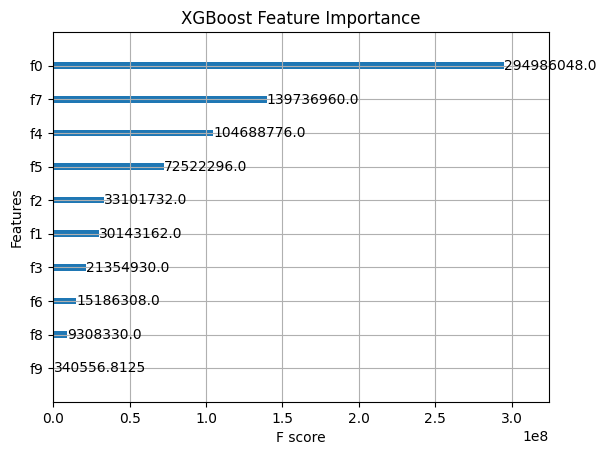

100%|===================| 42237/42436 [01:18<00:00]        

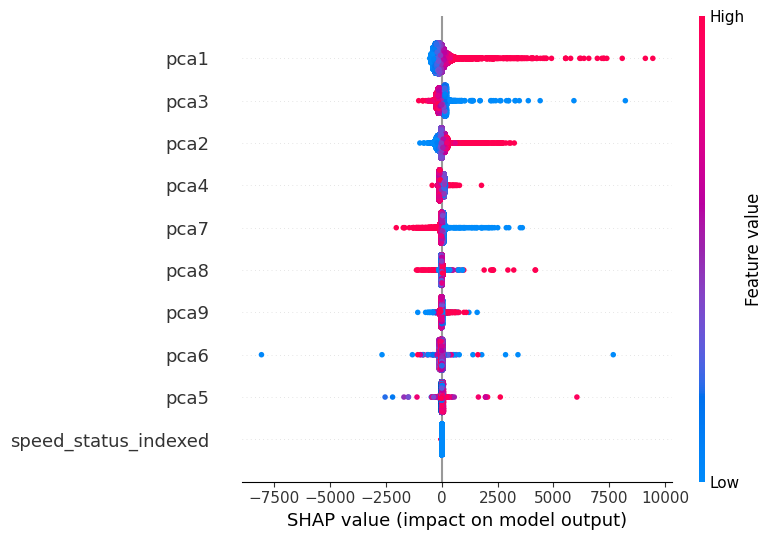

In [31]:
import shap
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd

# XGBoost Feature Importance
xgb.plot_importance(xgb_best, importance_type='gain', max_num_features=10)
plt.title("XGBoost Feature Importance")
plt.show()

if not isinstance(X_train_reg, pd.DataFrame):
    X_train_reg = pd.DataFrame(X_train_reg, columns=final_features) 
    
# Take 10% random sample from X_train
X_sample = X_train_reg.sample(frac=0.1, random_state=42)  # random_state for reproducibility

# Create SHAP explainer with sampled data
explainer = shap.TreeExplainer(xgb_best, X_sample)
shap_values = explainer.shap_values(X_sample)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_sample)

shap.initjs()
# SHAP Force Plot for first prediction (Expected Value for Regression)
shap.force_plot(explainer.expected_value, shap_values[0], X_sample.iloc[0, :])

                Feature  SHAP Importance
0                  pca1       235.523127
2                  pca3       124.584127
1                  pca2       124.049689
3                  pca4        81.187506
6                  pca7        46.087341
7                  pca8        18.330291
8                  pca9        17.489250
5                  pca6        10.107654
4                  pca5         8.631112
9  speed_status_indexed         0.009639


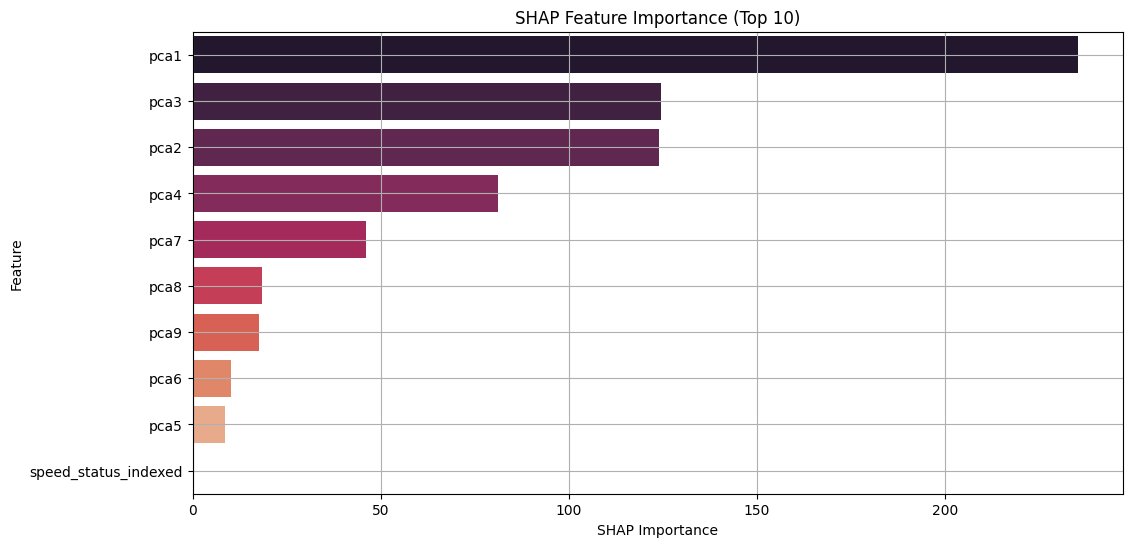

In [32]:
import seaborn as sns

# Convert X_train to DataFrame if not already
# if not isinstance(X_train, pd.DataFrame):
#     X_train = pd.DataFrame(X_train, columns=features) 

# SHAP Feature Importance (Bar Plot)
shap_df = pd.DataFrame({
    "Feature": X_train_reg.columns,
    "SHAP Importance": np.abs(shap_values).mean(axis=0)
})

if not isinstance(X_train_reg, pd.DataFrame):
    X_train_reg = pd.DataFrame(X_train_reg, columns = feature_names) #feature_names is a list of the column names.

shap_df = shap_df.sort_values(by="SHAP Importance", ascending=False)
print(shap_df.head(10))

plt.figure(figsize=(12, 6))
sns.barplot(x="SHAP Importance", y="Feature", data=shap_df.head(10), palette="rocket", hue="Feature", legend=False)
plt.title("SHAP Feature Importance (Top 10)")
plt.grid(True)
plt.show()

##### Key Observations for ETA Prediction:

In [13]:
# Feature SHAP Importance Interpretation
# delivery_time_delay	193.68	The most critical factor — any delay at the delivery stage significantly impacts the ETA.
# speed_kmh	37.20	Slower driving speeds increase ETA — highly influenced by traffic conditions.
# delivery_distance_km	35.14	Longer distances naturally increase ETA, but its impact is lower than delivery delays.
# hour_of_day	2.25	Certain hours (peak traffic hours like morning or evening) increase ETA.
# city_order_count	1.15	Higher demand in the city likely causes longer waiting times and affects the overall ETA.
# delivery_order_count	0.80	More deliverys nearby may result in driver unavailability and longer waiting times.
# avg_delivery_time_minutes	0.68	Higher average delivery times directly increase ETA.
# day_of_week	0.67	Certain days (like weekends or holidays) might show longer ETAs due to higher order volumes.
# month	0.26	Seasonality impact — delays may be longer in holiday seasons or bad weather months.
# cluster	0.19	Some areas (high traffic or remote locations) may consistently have longer ETAs.

##### Hyperparameter Tuning for Random Forest

In [69]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# # Cache Data for Faster Computation
# train_data_features.cache()
# test_data_features.cache()

# Random Forest Regressor
rf = RandomForestRegressor(featuresCol='features', labelCol='delivery_eta_minutes', seed=42, subsamplingRate=0.8)  # 80% Data for Each Tree

# Hyperparameter Grid (Lite Version - Fast Processing)
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .addGrid(rf.maxBins, [32]) \
    .build()

# Evaluators
evaluator_rmse = RegressionEvaluator(labelCol='delivery_eta_minutes', predictionCol='prediction', metricName='rmse')
evaluator_mse = RegressionEvaluator(labelCol='delivery_eta_minutes', predictionCol='prediction', metricName='mse')
evaluator_mae = RegressionEvaluator(labelCol='delivery_eta_minutes', predictionCol='prediction', metricName='mae')

# Cross Validator with Parallelism
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator_rmse,
                          numFolds=3,  # Faster Cross Validation
                          parallelism=4,  # Number of Cores for Parallel Jobs
                          seed=42)

# Fit Model
print("Training Model with Hyperparameter Tuning...")
cv_model = crossval.fit(train_data_features)
print("Model Training Done!")

# Best Model
best_rf_model = cv_model.bestModel
print("\n Best Hyperparameters:")
print("numTrees:", best_rf_model.getNumTrees, 
      "maxDepth:", best_rf_model.getMaxDepth(),
      "maxBins:", best_rf_model.getMaxBins())

# Predictions
rf_predictions = best_rf_model.transform(test_data_features)

# Evaluation
rmse = evaluator_rmse.evaluate(rf_predictions)
mse = evaluator_mse.evaluate(rf_predictions)
mae = evaluator_mae.evaluate(rf_predictions)

print("\nModel Performance Metrics:")
print("MSE :", mse)
print("RMSE:", rmse)
print("MAE :", mae)

Training Model with Hyperparameter Tuning...
Model Training Done!

 Best Hyperparameters:
numTrees: 100 maxDepth: 10 maxBins: 32

Model Performance Metrics:
MSE : 137242.0707425729
RMSE: 370.4619693606523
MAE : 55.548185734626976


##### Hyperparameter Tuning for Linear Regression

In [131]:
from pyspark.ml.feature import StandardScaler, PolynomialExpansion
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Standardize PCA features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

# Add Polynomial Features (degree 2)
poly_expansion = PolynomialExpansion(inputCol="scaled_features", outputCol="poly_features", degree=2)

# Update Pipeline
pipeline_reg = Pipeline(stages=[assembler_reg, scaler, poly_expansion])

# Transform Data (train & test separately)
train_data_features = pipeline_reg.fit(train_reg).transform(train_reg)
test_data_features = pipeline_reg.fit(train_reg).transform(test_reg)  # Fixed: Apply to test_reg

# Define Linear Regression Model
lr = LinearRegression(featuresCol="poly_features", labelCol="delivery_eta_minutes")

# Define parameter grid for hyperparameter tuning
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 0.5, 1.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .build())

# Define evaluator
rmse_evaluator = RegressionEvaluator(labelCol="delivery_eta_minutes", predictionCol="prediction", metricName="rmse")

# Define cross-validator for hyperparameter tuning
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=rmse_evaluator,
                          numFolds=5)  # 5-fold cross-validation

# Train model with cross-validation
cv_model = crossval.fit(train_data_features)

# Make predictions on test set
cv_predictions = cv_model.transform(test_data_features).withColumn("prediction", round("prediction", 0))

# Evaluate final tuned model
rmse_cv = rmse_evaluator.evaluate(cv_predictions)
mse_cv = RegressionEvaluator(labelCol="delivery_eta_minutes", predictionCol="prediction", metricName="mse").evaluate(cv_predictions)
mae_cv = RegressionEvaluator(labelCol="delivery_eta_minutes", predictionCol="prediction", metricName="mae").evaluate(cv_predictions)

print(f"Tuned RMSE: {rmse_cv:.4f}")
print(f"Tuned MSE: {mse_cv:.4f}")
print(f"Tuned MAE: {mae_cv:.4f}")

# Show predictions
cv_predictions.select("delivery_eta_minutes", "prediction").show(10)

Tuned RMSE: 3.9941
Tuned MSE: 15.9530
Tuned MAE: 2.8345
+--------------------+----------+
|delivery_eta_minutes|prediction|
+--------------------+----------+
|              1841.0|    1832.0|
|              7781.0|    7777.0|
|               568.0|     565.0|
|               379.0|     378.0|
|               384.0|     383.0|
|               628.0|     627.0|
|               364.0|     362.0|
|               382.0|     381.0|
|               371.0|     375.0|
|               410.0|     408.0|
+--------------------+----------+
only showing top 10 rows



##### Save the Model

In [132]:
eta_model = "regression_model_delivery"
lr_model.write().overwrite().save(eta_model)
print(f"Model saved at {eta_model}")

Model saved at regression_model_delivery


##### Load Model for Future Predictions

In [133]:
from pyspark.ml.regression import LinearRegressionModel

# Load the saved Linear Regression model
loaded_model = LinearRegressionModel.load(eta_model)
print("Linear Regression Model loaded successfully!")

Linear Regression Model loaded successfully!


#### Classification models for Delay detection (Logistic Regression, Decision Tree, Neural Networks)

In [ ]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, MultilayerPerceptronClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Assemble Features for Classification
classification_features = ["pca1", "pca2", "pca3", "pca4", "pca5", "pca6", "pca7", "pca8", "pca9", "speed_status_indexed"]
assembler_cls = VectorAssembler(inputCols=classification_features, outputCol="features")

# Define Classification Models
log_reg = LogisticRegression(featuresCol="features", labelCol="is_delayed_index")

decision_tree = DecisionTreeClassifier(featuresCol="features", labelCol="is_delayed_index")

# Fix MLP Layers (Input = Features, Output = Classes)
num_features = len(classification_features)  # Should be 10
num_classes = train_cls.select("is_delayed_index").distinct().count()  # Should be 2 (0,1)

mlp = MultilayerPerceptronClassifier(
    featuresCol="features",
    labelCol="is_delayed_index",
    layers=[num_features, 8, 4, num_classes],  # Adjusted input and output layers
    maxIter=100
)

# Create Pipelines
pipeline_log_reg = Pipeline(stages=[assembler_cls, log_reg])
pipeline_dt = Pipeline(stages=[assembler_cls, decision_tree])
pipeline_mlp = Pipeline(stages=[assembler_cls, mlp])

# Train Models
log_reg_model = pipeline_log_reg.fit(train_cls)
dt_model = pipeline_dt.fit(train_cls)
mlp_model = pipeline_mlp.fit(train_cls)  # Should work now

# Make Predictions
log_reg_preds = log_reg_model.transform(test_cls)
dt_preds = dt_model.transform(test_cls)
mlp_preds = mlp_model.transform(test_cls)

# Evaluate Models
evaluator = MulticlassClassificationEvaluator(labelCol="is_delayed_index", metricName="accuracy")

log_reg_acc = evaluator.evaluate(log_reg_preds)
dt_acc = evaluator.evaluate(dt_preds)
mlp_acc = evaluator.evaluate(mlp_preds)

print(f"Logistic Regression Accuracy: {log_reg_acc:.4f}")
print(f"Decision Tree Accuracy: {dt_acc:.4f}")
print(f"Neural Network Accuracy: {mlp_acc:.4f}")

Logistic Regression Accuracy: 0.9987
Decision Tree Accuracy: 0.9619
Neural Network Accuracy: 0.9989


In [77]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Use `predictionCol="prediction"` for Binary Classification
auc_evaluator = BinaryClassificationEvaluator(labelCol="is_delayed_index", rawPredictionCol="prediction", metricName="areaUnderROC")

# Evaluate models
log_reg_auc = auc_evaluator.evaluate(log_reg_preds)
dt_auc = auc_evaluator.evaluate(dt_preds)
mlp_auc = auc_evaluator.evaluate(mlp_preds)

print(f"Logistic Regression AUC: {log_reg_auc:.4f}")
print(f"Decision Tree AUC: {dt_auc:.4f}")
print(f"Neural Network AUC: {mlp_auc:.4f}")

Logistic Regression AUC: 0.9964
Decision Tree AUC: 0.8783
Neural Network AUC: 0.9970


##### Hyperparameter tuning for Logistic Regression¶


In [89]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.types import IntegerType

feature_cols = ["speed_status_indexed", "pca1", "pca2", "pca3", "pca4", "pca5", "pca6", "pca7", "pca8", "pca9"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Convert to Integer type
train_cls = train_cls.withColumn("speed_status_indexed", col("speed_status_indexed").cast(IntegerType()))
test_cls = test_cls.withColumn("speed_status_indexed", col("speed_status_indexed").cast(IntegerType()))
train_cls = train_cls.withColumn("is_delayed_index", when(col("is_delayed_index") > 1, 1).otherwise(col("is_delayed_index")))
test_cls = test_cls.withColumn("is_delayed_index", when(col("is_delayed_index") > 1, 1).otherwise(col("is_delayed_index")))

# Define Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="is_delayed_index")

# Define Hyperparameter Grid
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 0.5])  # Regularization Parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])  # L1 vs L2 Regularization
             .build())

# Define Evaluator (AUC for Classification)
evaluator_auc = BinaryClassificationEvaluator(labelCol="is_delayed_index", metricName="areaUnderROC")

# Define CrossValidator
cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator_auc,
                    numFolds=3)  # 3-Fold Cross Validation

# Create a Pipeline (Feature Assembly + Cross Validation Model Training)
pipeline = Pipeline(stages=[assembler, cv])

# Train Logistic Regression with Cross Validation**
cvModel = pipeline.fit(train_cls)  

# Get the Best Model from Cross Validation
best_lr = cvModel.stages[-1].bestModel  

# # Get the Best Model
# best_lr = cvModel.bestModel

# Print Best Hyperparameters
print(f"Best Logistic Regression Model - regParam: {best_lr._java_obj.getRegParam()}, "
      f"elasticNetParam: {best_lr._java_obj.getElasticNetParam()}")

# Make Predictions on Test Data
test_predictions = cvModel.transform(test_cls)

# Evaluate Model Performance
test_auc = evaluator_auc.evaluate(test_predictions)
print(f"Logistic Regression AUC: {test_auc:.4f}")

# Define Accuracy Evaluator
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="is_delayed_index", metricName="accuracy")
accuracy = evaluator_accuracy.evaluate(test_predictions)

# Define Precision Evaluator
evaluator_precision = MulticlassClassificationEvaluator(labelCol="is_delayed_index", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(test_predictions)

# Define Recall Evaluator
evaluator_recall = MulticlassClassificationEvaluator(labelCol="is_delayed_index", metricName="weightedRecall")
recall = evaluator_recall.evaluate(test_predictions)

# 9️Print Final Metrics
print(f"Logistic Regression Accuracy: {accuracy:.4f}")
print(f"Logistic Regression Precision: {precision:.4f}")
print(f"Logistic Regression Recall: {recall:.4f}")

Best Logistic Regression Model - regParam: 0.01, elasticNetParam: 1.0
Logistic Regression AUC: 0.9920
Logistic Regression Accuracy: 0.9565
Logistic Regression Precision: 0.9575
Logistic Regression Recall: 0.9565


##### Hyperparameter tuning of Decision Tree

In [90]:
# Import necessary libraries
from pyspark.sql.functions import col, when
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Step 1: Ensure `speed_status_indexed` has only 2 classes (0 and 1)
# train_cls = train_cls.withColumn("speed_status_indexed", 
#                                  when(col("speed_status") == "Realistic Speed", 0)
#                                  .otherwise(1))

# test_cls = test_cls.withColumn("speed_status_indexed", 
#                                 when(col("speed_status") == "Realistic Speed", 0)
#                                 .otherwise(1))

# indexer = StringIndexer(inputCol="speed_status", outputCol="speed_status_indexed", handleInvalid="keep")
# train_cls = indexer.fit(train_cls).transform(train_cls)
# test_cls = indexer.fit(test_cls).transform(test_cls)

# Convert to Integer type
train_cls = train_cls.withColumn("speed_status_indexed", col("speed_status_indexed").cast(IntegerType()))
test_cls = test_cls.withColumn("speed_status_indexed", col("speed_status_indexed").cast(IntegerType()))


# Re-index to ensure binary classification
# indexer = StringIndexer(inputCol="is_delayed", outputCol="is_delayed_index", handleInvalid="keep")
# train_cls = indexer.fit(train_cls).transform(train_cls)
# test_cls = indexer.fit(test_cls).transform(test_cls)

# Force labels to be only 0 or 1
train_cls = train_cls.withColumn("is_delayed_index", when(col("is_delayed_index") > 1, 1).otherwise(col("is_delayed_index")))
test_cls = test_cls.withColumn("is_delayed_index", when(col("is_delayed_index") > 1, 1).otherwise(col("is_delayed_index")))


# Step 2: Define Features and Assemble
feature_cols = ["speed_status_indexed", "pca1", "pca2", "pca3", "pca4", "pca5", "pca6", "pca7", "pca8", "pca9"]

# VectorAssembler to create feature vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_cls = assembler.transform(train_cls)
test_cls = assembler.transform(test_cls)

# Step 3: Define Decision Tree Model
dt = DecisionTreeClassifier(featuresCol="features", labelCol="is_delayed_index", maxDepth=5)

# Step 4: Hyperparameter Tuning with Cross-Validation
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [3, 5, 7, 10]) \
    .addGrid(dt.minInstancesPerNode, [1, 5, 10]) \
    .build()

evaluator = BinaryClassificationEvaluator(labelCol="is_delayed_index", metricName="areaUnderROC")
evaluator_acc = MulticlassClassificationEvaluator(labelCol="is_delayed_index", predictionCol="prediction", metricName="accuracy")

cv = CrossValidator(estimator=dt,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3)  # 3-fold cross-validation

# Step 5: Train Decision Tree with Best Hyperparameters
cvModel = cv.fit(train_cls)

# Get best model
best_dt = cvModel.bestModel

# Step 6: Evaluate on Test Data
predictions = best_dt.transform(test_cls)

auc = evaluator.evaluate(predictions)
accuracy = evaluator_acc.evaluate(predictions)

# Step 7: Print Results
print(f"Best Decision Tree Model - maxDepth: {best_dt.getMaxDepth()}, minInstancesPerNode: {best_dt.getMinInstancesPerNode()}")
print(f"Decision Tree AUC: {auc:.4f}")
print(f"Decision Tree Accuracy: {accuracy:.4f}")

Best Decision Tree Model - maxDepth: 10, minInstancesPerNode: 1
Decision Tree AUC: 0.9566
Decision Tree Accuracy: 0.9830


In [99]:
from pyspark.ml.feature import IndexToString

# Step 1: Make Predictions on Test Data
predictions = best_dt.transform(test_cls)

# Step 2: Map speed_status_indexed to human-readable labels
predictions = predictions.withColumn(
    "speed_status",
    when(col("speed_status_indexed") == 0, "Realistic Speed")
    .when(col("speed_status_indexed") == 1, "Unrealistic Speed")
    .otherwise("Unknown")  # Fallback in case of unexpected values
)

# Step 2: Select and Show Sample Predictions
predictions.select("speed_status", "is_delayed_index", "prediction", "probability").show(10, truncate=False)

# Step 3: Evaluate the Performance
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Accuracy Calculation
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="is_delayed_index", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)

# Precision Calculation
precision_evaluator = MulticlassClassificationEvaluator(labelCol="is_delayed_index", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)

# Recall Calculation
recall_evaluator = MulticlassClassificationEvaluator(labelCol="is_delayed_index", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions)

# Display Metrics
print(f"Decision Tree Delay Prediction Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Step 4: Confusion Matrix
from pyspark.mllib.evaluation import MulticlassMetrics

# Convert predictions to RDD format for confusion matrix
prediction_and_labels = predictions.select("prediction", "is_delayed_index").rdd.map(lambda x: (float(x[0]), float(x[1])))

# Compute Confusion Matrix
metrics = MulticlassMetrics(prediction_and_labels)
print(f"Confusion Matrix:\n{metrics.confusionMatrix().toArray()}")

+---------------+----------------+----------+-----------------------------------------+
|speed_status   |is_delayed_index|prediction|probability                              |
+---------------+----------------+----------+-----------------------------------------+
|Realistic Speed|1.0             |1.0       |[0.0,1.0]                                |
|Realistic Speed|1.0             |1.0       |[0.0,1.0]                                |
|Realistic Speed|1.0             |0.0       |[0.999957702036224,4.229796377602382E-5] |
|Realistic Speed|1.0             |0.0       |[0.999957702036224,4.229796377602382E-5] |
|Realistic Speed|1.0             |0.0       |[0.9994875298940895,5.124701059104886E-4]|
|Realistic Speed|1.0             |0.0       |[0.96415770609319,0.035842293906810034]  |
|Realistic Speed|1.0             |0.0       |[0.7105263157894737,0.2894736842105263]  |
|Realistic Speed|1.0             |1.0       |[0.35,0.65]                              |
|Realistic Speed|1.0            

In [ ]:
# Looking the the above table I ran the model on the test dataset and obtained: prediction = 1.0 (Delayed) or 0.0 (Not Delayed)
#                                                                                Probability = Confidence score for each class
# and confusion matrix we have 795 False Positives (FP) and 1155 False Negatives (FN) were observed.
# To improve this model meaning reducing the False Negatives(cases where the model misses delays). If minimizing missed delays is critical,
# we'll try different threshold. By default, the Decision Tree assigns prediction=1 if probability[1] > 0.5.
# I selected Threshold = 0.3 as it gives a balance between recall and precision while reducing false negatives.

In [114]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# Set new threshold (adjust as needed)
new_threshold = 0.3  # Change this value to fine-tune

# Define UDF to apply the new threshold
def adjust_threshold(probability_vector, threshold=new_threshold):
    return 1.0 if probability_vector[1] > threshold else 0.0

adjust_threshold_udf = udf(adjust_threshold, DoubleType())

# Apply threshold adjustment to predictions
adjusted_predictions = predictions.withColumn("adjusted_prediction", adjust_threshold_udf("probability"))

# Evaluate new model performance
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="is_delayed_index", predictionCol="adjusted_prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="is_delayed_index", predictionCol="adjusted_prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="is_delayed_index", predictionCol="adjusted_prediction", metricName="weightedRecall")

new_accuracy = evaluator_accuracy.evaluate(adjusted_predictions)
new_precision = evaluator_precision.evaluate(adjusted_predictions)
new_recall = evaluator_recall.evaluate(adjusted_predictions)

# Compute new confusion matrix
new_confusion_matrix = adjusted_predictions.groupBy("is_delayed_index", "adjusted_prediction").count().orderBy("is_delayed_index", "adjusted_prediction")
new_confusion_matrix.show()

# Print updated metrics
print(f"Decision Tree with Adjusted Threshold ({new_threshold}):")
print(f"New Accuracy: {new_accuracy:.4f}")
print(f"New Precision: {new_precision:.4f}")
print(f"New Recall: {new_recall:.4f}")

+----------------+-------------------+-----+
|is_delayed_index|adjusted_prediction|count|
+----------------+-------------------+-----+
|             0.0|                0.0|94729|
|             0.0|                1.0| 1330|
|             1.0|                0.0|  668|
|             1.0|                1.0| 9523|
+----------------+-------------------+-----+

Decision Tree with Adjusted Threshold (0.3):
New Accuracy: 0.9812
New Precision: 0.9819
New Recall: 0.9812


##### Save the Model

In [117]:
delay_model = "classification_model_delivery"
best_dt.write().overwrite().save(delay_model)
print(f"Model saved at {delay_model}")

Model saved at classification_model_delivery


##### Load Model for Future Predictions

In [128]:
from pyspark.ml.classification import DecisionTreeClassificationModel
from pyspark.sql.functions import col, expr
# Reload the saved Decision Tree model
loaded_dt = DecisionTreeClassificationModel.load("classification_model_delivery")
print("Model loaded successfully!")

# Get raw predictions
new_predictions = loaded_dt.transform(test_cls)

# Define UDF to extract second probability value (index 1)
def extract_prob(v):
    return float(v[1]) if len(v) > 1 else 0.0

extract_prob_udf = udf(extract_prob)

# Apply UDF to extract the probability of delay (index 1)
new_predictions = new_predictions.withColumn("delay_probability", extract_prob_udf(col("probability")))

# Apply threshold
adjusted_predictions = new_predictions.withColumn(
    "adjusted_prediction",
    when(col("delay_probability") > 0.25, 1.0).otherwise(0.0)
)

# Show sample predictions
adjusted_predictions.select("is_delayed_index", "delay_probability", "adjusted_prediction").show(10)

Model loaded successfully!
+----------------+--------------------+-------------------+
|is_delayed_index|   delay_probability|adjusted_prediction|
+----------------+--------------------+-------------------+
|             1.0|                 1.0|                1.0|
|             1.0|                 1.0|                1.0|
|             1.0|4.229796377602382E-5|                0.0|
|             1.0|4.229796377602382E-5|                0.0|
|             1.0|5.124701059104886E-4|                0.0|
|             1.0|0.035842293906810034|                0.0|
|             1.0|  0.2894736842105263|                1.0|
|             1.0|                0.65|                1.0|
|             1.0|8.215872037793011E-4|                0.0|
|             1.0|  0.2894736842105263|                1.0|
+----------------+--------------------+-------------------+
only showing top 10 rows

